In [1]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

!mkdir -p drive
!google-drive-ocamlfuse drive

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 144328 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.22-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.22-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.22-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


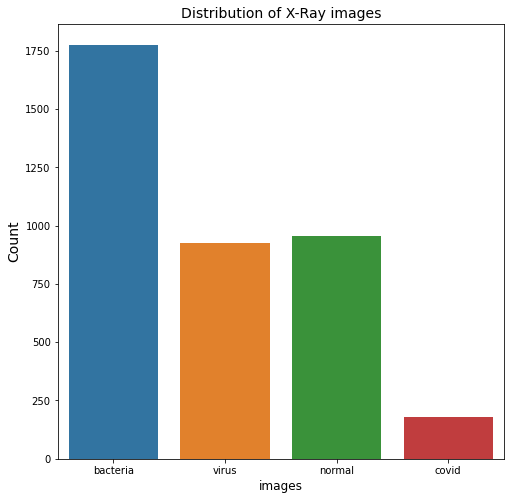

(3834, 224, 224, 3)
(3834, 1)
(1644, 224, 224, 3)
(1644, 1)
Number of class:4


In [2]:
import sys
sys.path.insert(0,'drive/data_NPZ')

import os 
import glob
import cv2
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import cv2

from sklearn.model_selection import train_test_split

def load_data_training_and_test(path):
    npzfile = np.load(path + "4class_forAlex_all_training_data.npz")
    train = npzfile['arr_0']
    
    npzfile = np.load(path + "4class_forAlex_all_training_label.npz")
    train_labels = npzfile['arr_0']
    
    train_set, test_set = train_test_split(train,test_size=0.3,random_state=0)
    train_label,test_label=train_test_split(train_labels,test_size=0.3,random_state=0)

    return (train_set,train_label),(test_set,test_label)


path='drive/data_NPZ/alex-net/'

(x_train, y_train), (x_test, y_test) = load_data_training_and_test(path)



df = pd.DataFrame(data=y_train, columns=["status"])

import seaborn as sns

fig, ax = plt.subplots(figsize=(8,8))
sns.countplot('status',data=df)
ax.set_title('Distribution of X-Ray images', fontsize=14)
ax.set_xlabel('images', fontsize=12)
ax.set_ylabel('Count', fontsize=14)
plt.show()


y_train = y_train.reshape(y_train.shape[0], 1)
y_test = y_test.reshape(y_test.shape[0], 1)

# Change our image type to float32 data type
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')


print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)




from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
y_test = mlb.fit_transform(y_test)

mlb2=MultiLabelBinarizer()
y_train=mlb2.fit_transform(y_train)

num_classes = y_test.shape[1]
print("Number of class:"+str(num_classes))


#    rescale=1./255,
from keras_preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    shear_range=0.2,
    rotation_range=5,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rotation_range=5
 )

datagen.fit(x_train)
test_datagen.fit(x_test)

In [3]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D



input_shape = (224, 224, 3)

def get_netork():
      model = Sequential()


      model.add(Conv2D(96,(11,11),activation="relu",input_shape=input_shape,strides=(4,4),padding='valid'))
      model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2), padding='valid'))


      # 2nd Convolutional Layer

      model.add(Conv2D(256,kernel_size=(11,11),activation="relu",strides=(1,1), padding='valid'))

      model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2),padding='valid'))


      model.add(Conv2D(384,(3,3),activation="relu",padding="valid",strides=(1,1)))


      model.add(Conv2D(384,(3,3),activation="relu",padding="valid",strides=(1,1)))


      model.add(Conv2D(256,(3,3),activation="relu",padding="valid",strides=(1,1)))

      model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2),padding='valid'))


            #↨ Fully connencted Layer

      model.add(Flatten())

      model.add(Dense(4096, input_shape=(224*224*1,)))
      model.add(Activation("relu"))#kernel_initializer='random_normal'
      model.add(Dropout(0.4))


      model.add(Dense(4096))
      model.add(Activation("relu"))#kernel_initializer='random_normal'
      model.add(Dropout(0.4))

      model.add(Dense(1000))
      model.add(Activation("relu"))#kernel_initializer='random_normal'
      model.add(Dropout(0.4))


      model.add(Dense(num_classes))#kernel_initializer='random_normal'
      model.add(Activation("softmax"))

      #model.summary()

      return model

Using TensorFlow backend.


Epoch 1/40
60/60 [==============================] - 58s 969ms/step - loss: 3.4105 - accuracy: 0.4473 - val_loss: 0.8520 - val_accuracy: 0.4878

Epoch 00001: val_accuracy improved from -inf to 0.48783, saving model to drive/best_weights_for_AlexNet_4class.hdf5
Epoch 2/40
60/60 [==============================] - 49s 813ms/step - loss: 1.1353 - accuracy: 0.5175 - val_loss: 1.1496 - val_accuracy: 0.5803

Epoch 00002: val_accuracy improved from 0.48783 to 0.58029, saving model to drive/best_weights_for_AlexNet_4class.hdf5
Epoch 3/40
60/60 [==============================] - 48s 806ms/step - loss: 1.0433 - accuracy: 0.5845 - val_loss: 0.8640 - val_accuracy: 0.6131

Epoch 00003: val_accuracy improved from 0.58029 to 0.61314, saving model to drive/best_weights_for_AlexNet_4class.hdf5
Epoch 4/40
60/60 [==============================] - 49s 811ms/step - loss: 1.0359 - accuracy: 0.5949 - val_loss: 0.9454 - val_accuracy: 0.6484

Epoch 00004: val_accuracy improved from 0.61314 to 0.64842, saving mod

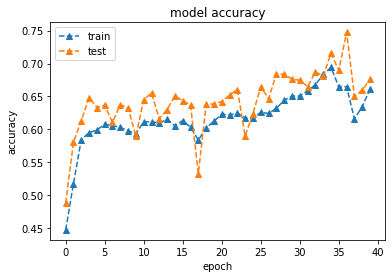

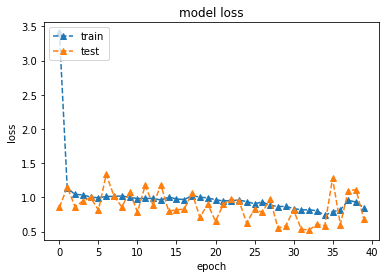

In [4]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping

from keras.optimizers import SGD,Adam,RMSprop,Adadelta,Adagrad,Adamax
opt = Adam()

#opt = Adam(lr= 0.001,decay=1e-6)
#opt=keras.optimizers.rmsprop(lr=1,decay=1e-6)
#opt=keras.optimizers.adam(lr=1)


model=get_netork()
model.compile(loss='categorical_crossentropy', #multiple class
              optimizer=opt,
              metrics=['accuracy'])

#print(model.summary())


early_stop=EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=20,
                              verbose=0, mode='auto')

#print(model.summary())



weight_name="drive/best_weights_for_AlexNet_4class.hdf5"
checkpointer = ModelCheckpoint(filepath=weight_name, 
                               monitor = 'val_accuracy',
                               verbose=1, 
                               save_best_only=True)


history=model.fit_generator(datagen.flow(x_train,y_train,batch_size=64),callbacks=[checkpointer,early_stop],validation_data = test_datagen.flow(x_test,y_test)
                            ,epochs=40)

"""
history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_test, y_test),
          shuffle=True)"""

model.save("drive/AlexNet_4class_with_AUG.h5")

print("\n")

import matplotlib.pyplot as plt
# Plot Accuracy
print(history.history.keys())
plt.plot(history.history['accuracy'],'^--')
plt.plot(history.history['val_accuracy'],'^--')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Plot Loss
plt.plot(history.history['loss'],'^--')
plt.plot(history.history['val_loss'],'^--')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

[0 0 0 ... 1 3 0]


[[647   8  42  57]
 [ 28  47   9   0]
 [ 29   2 350   6]
 [212   5  41 161]]


Confusion matrix, without normalization


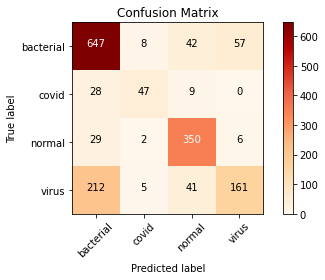

In [5]:
from scipy import interp
from itertools import cycle
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import auc


model.load_weights(weight_name)

y_predicted =  model.predict_classes(x_test)
#print(y_predicted)

#print(y_test)

y_true = np.argmax(y_test, axis=1)
print(y_true)


print("\n")

from sklearn.metrics import confusion_matrix


classes=['bacterial','covid', 'normal','virus']


confusion_matrix=confusion_matrix(y_true, y_predicted,labels=[0,1,2,3])

print(confusion_matrix)
print("\n")



#plot confusion matrix

def plot_confusion_matrix(confusion_matrix, classes,
                          normalize=False):
    cmap="OrRd"
    import itertools
    if normalize:
        confusion_matrix = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(confusion_matrix, interpolation='nearest', cmap=cmap)
    plt.title("Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = confusion_matrix.max() / 2.
    for i, j in itertools.product(range(confusion_matrix.shape[0]), range(confusion_matrix.shape[1])):
        plt.text(j, i, format(confusion_matrix[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if confusion_matrix[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

plt.figure()
plot_confusion_matrix(confusion_matrix, classes)


In [6]:

print("\n")

from sklearn.metrics import classification_report
print(classification_report(y_true, y_predicted,target_names=classes))





print("\n")



              precision    recall  f1-score   support

   bacterial       0.71      0.86      0.77       754
       covid       0.76      0.56      0.64        84
      normal       0.79      0.90      0.84       387
       virus       0.72      0.38      0.50       419

    accuracy                           0.73      1644
   macro avg       0.74      0.68      0.69      1644
weighted avg       0.73      0.73      0.71      1644





/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


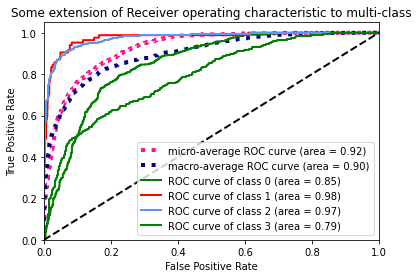

In [7]:
# Compute ROC curve and ROC area for each class
from scipy import interp
from itertools import cycle

y_preds =  model.predict(x_test)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_preds[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_preds.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
                       
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= num_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['green', 'red', 'cornflowerblue'])
for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, linewidth=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', linewidth=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()